<a href="https://colab.research.google.com/github/sooddhruv/Predicting-Trends-in-Ethical-Consumerism/blob/main/Correlation_analysis_test_2021_to_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas numpy textblob vaderSentiment yfinance matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 9.7 MB/s eta 0:00:00


<ipython-input-2-ba10e7f76b06>:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['timestamp'] = pd.to_datetime(df['timestamp'])


Plotting for Tesla


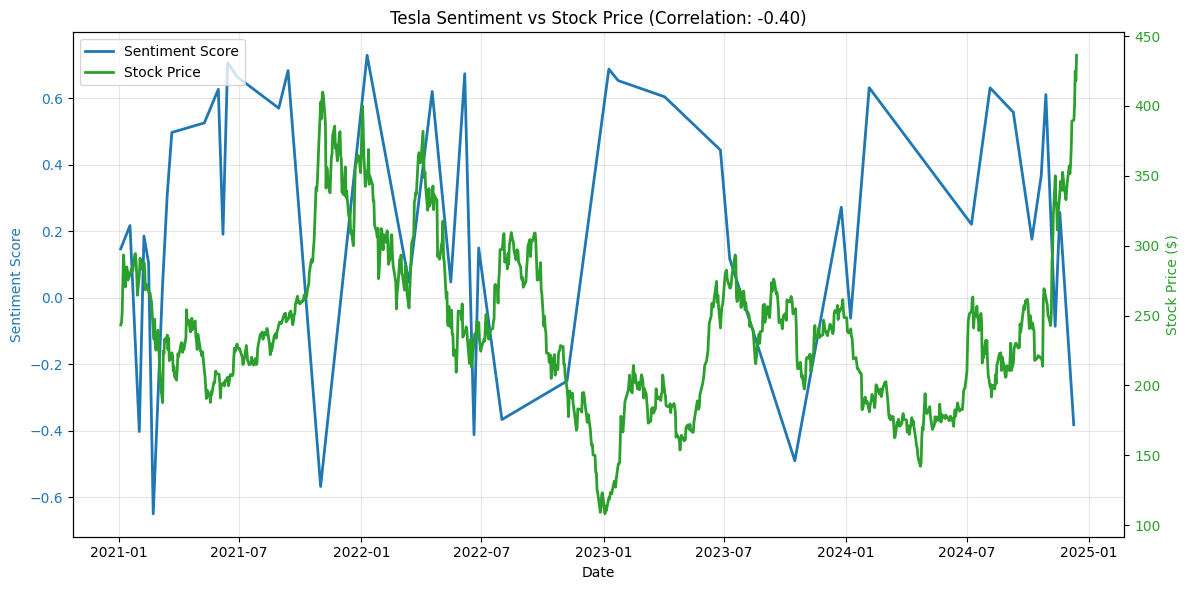

Plotting for Apple


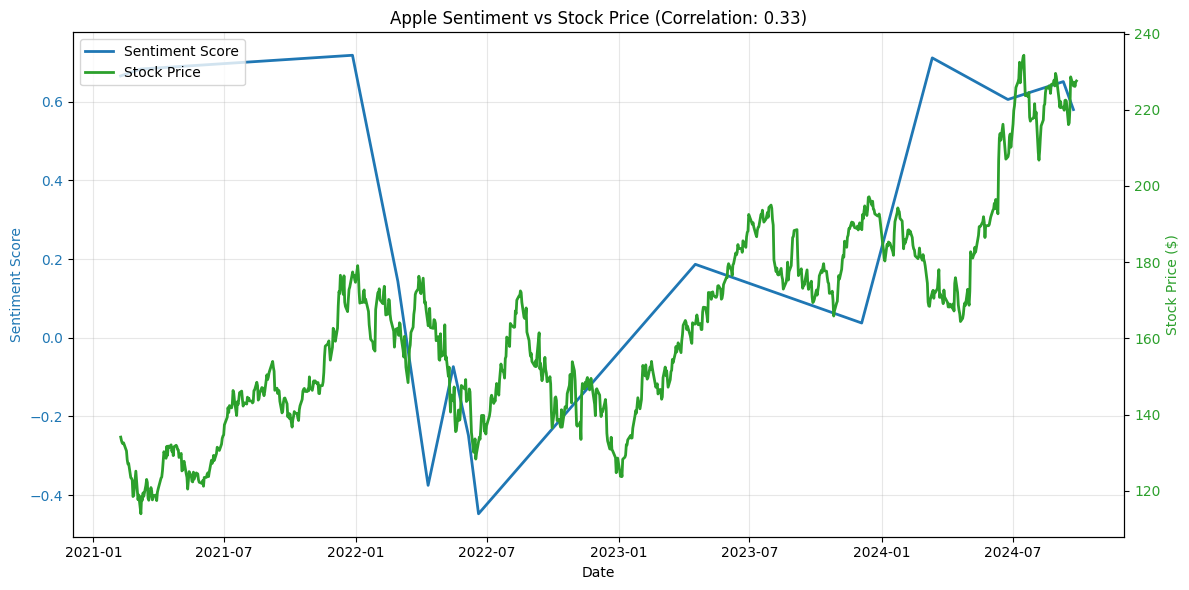

Plotting for Microsoft


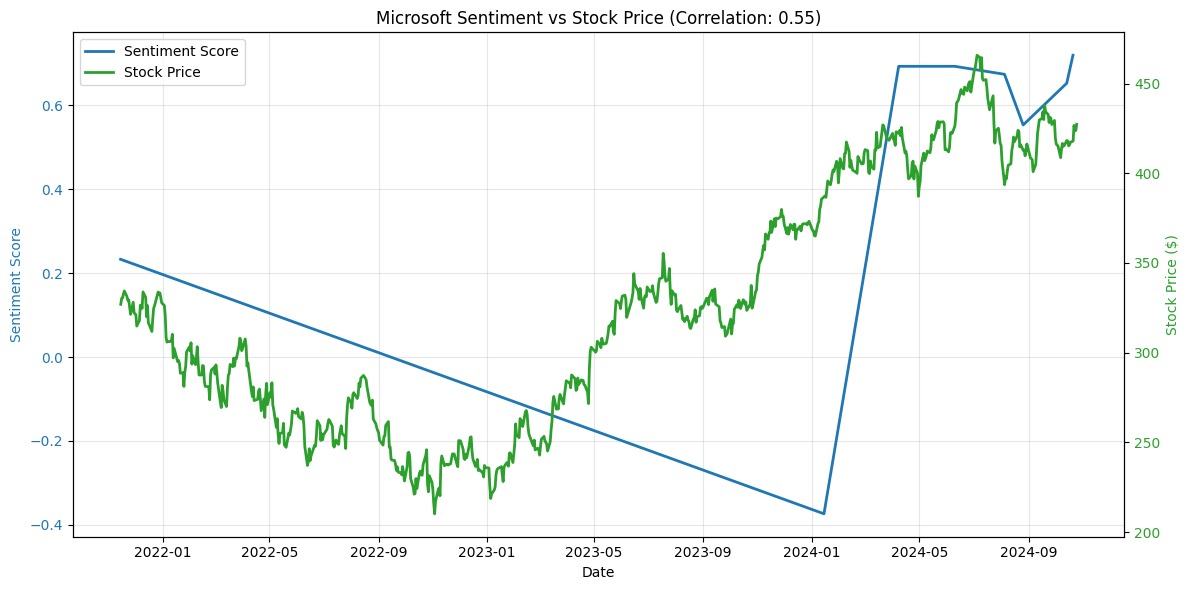

Plotting for Amazon


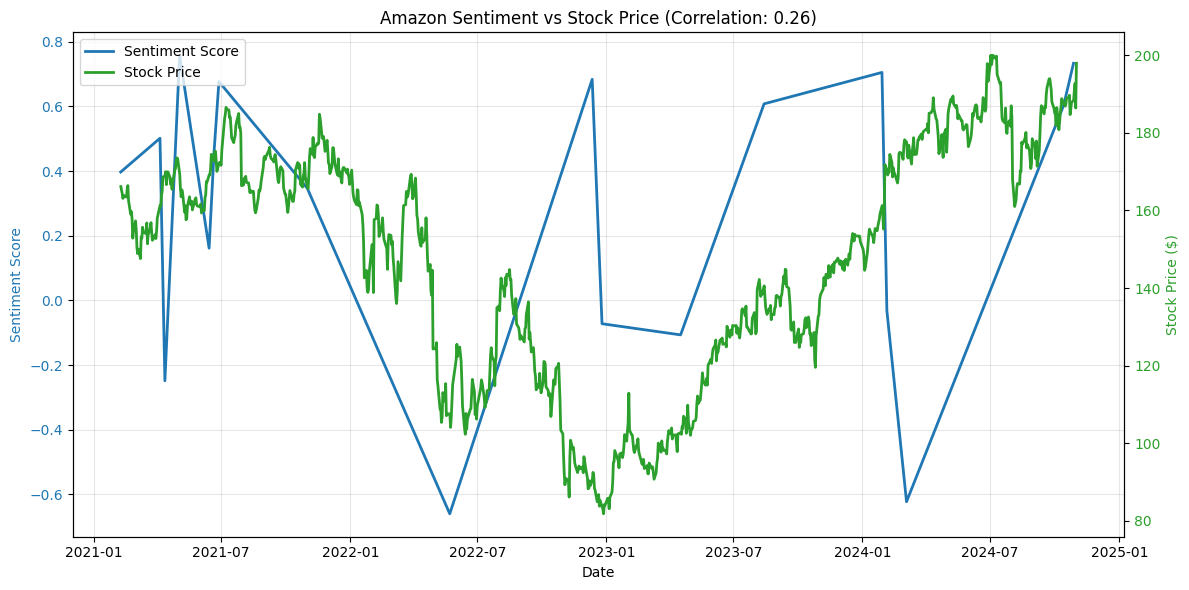

Plotting for Google


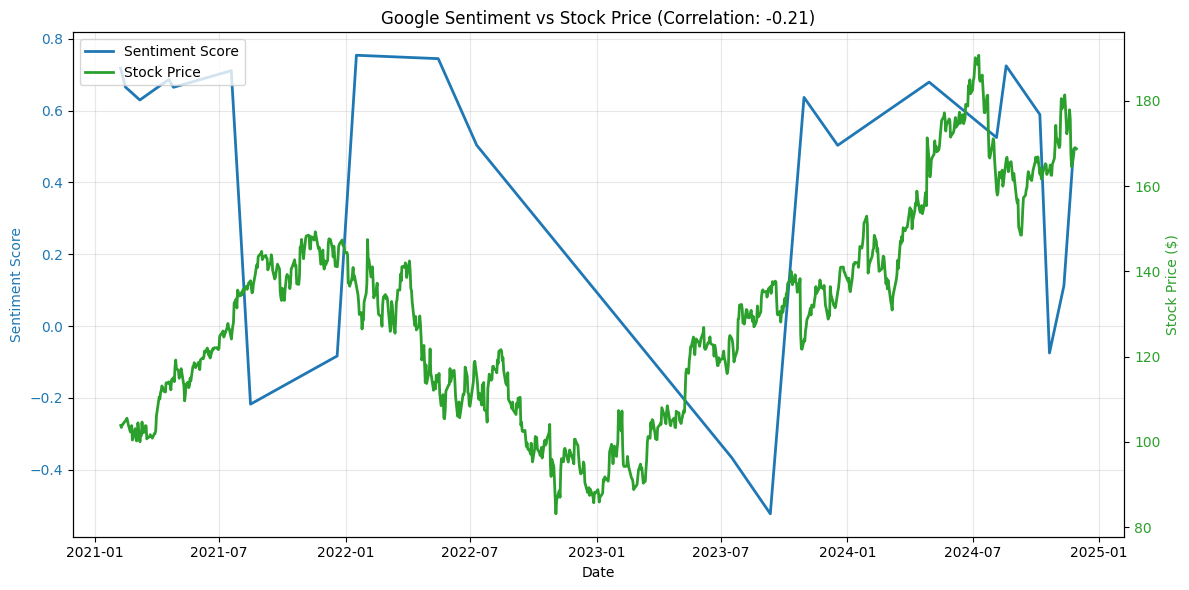

Plotting for Meta


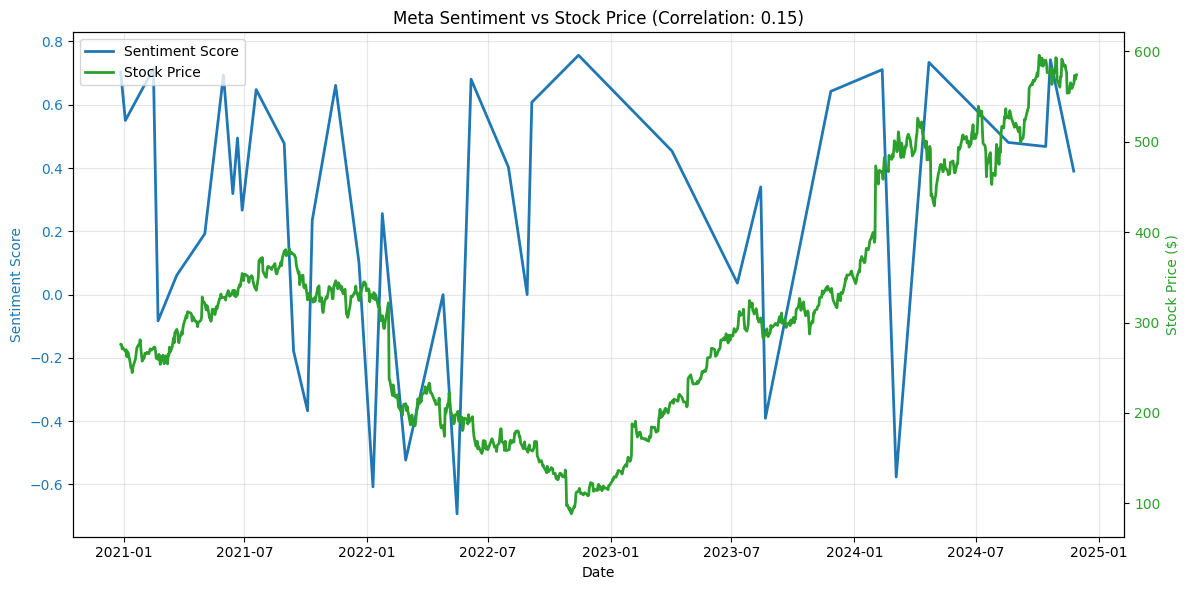

Plotting for Netflix


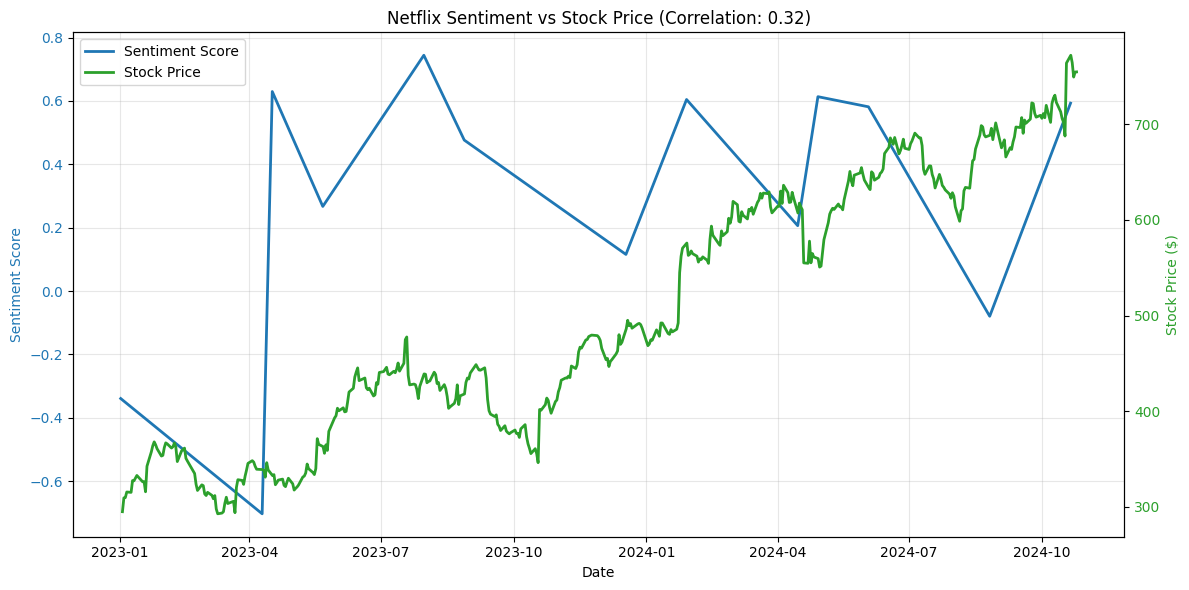

Plotting for NVIDIA


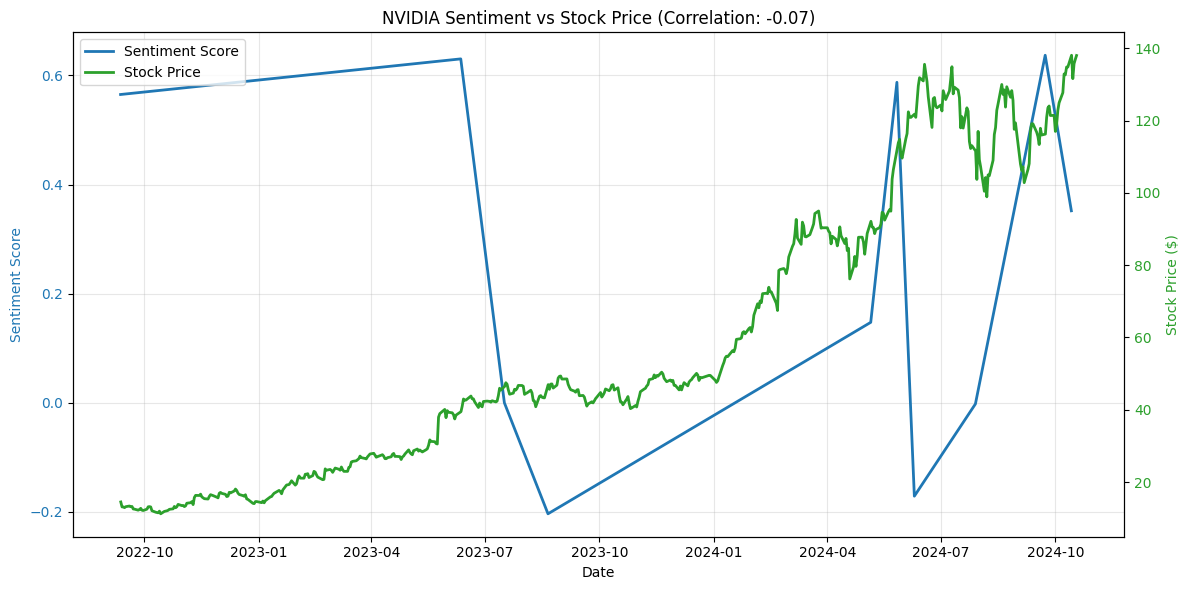

Plotting for Adobe


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


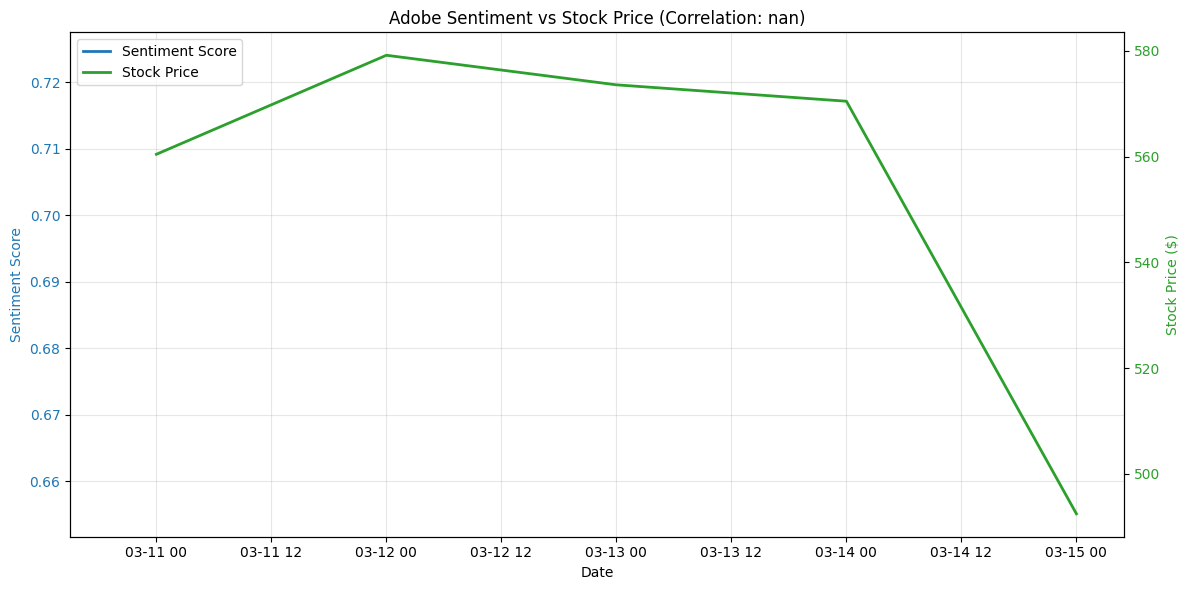

Plotting for Salesforce


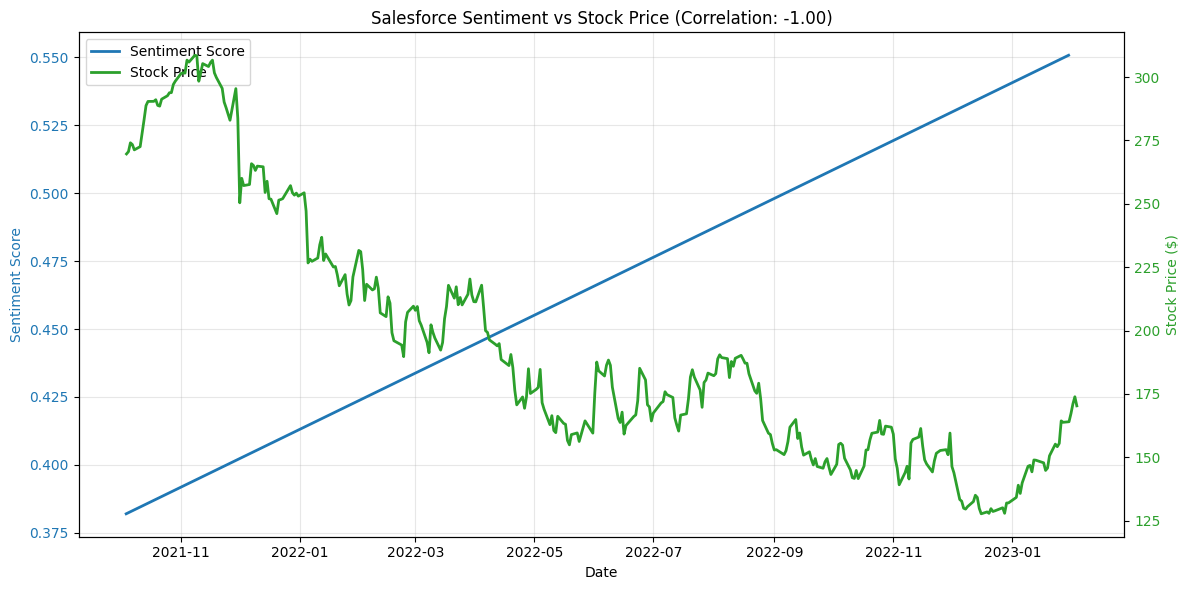

Plotting for Intel


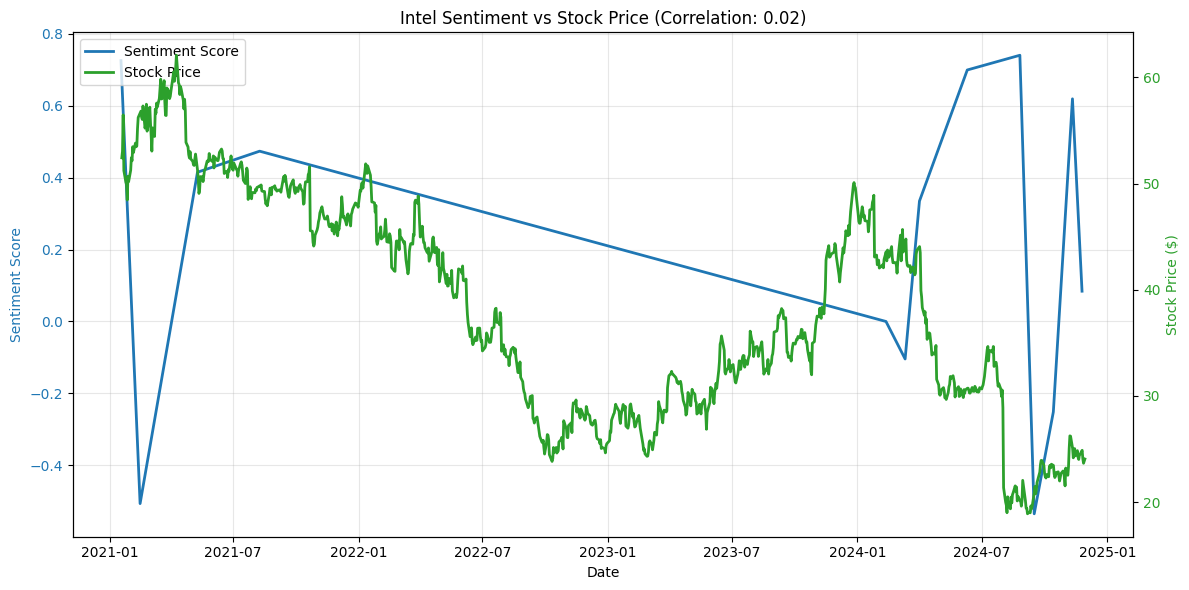

Plotting for Cisco


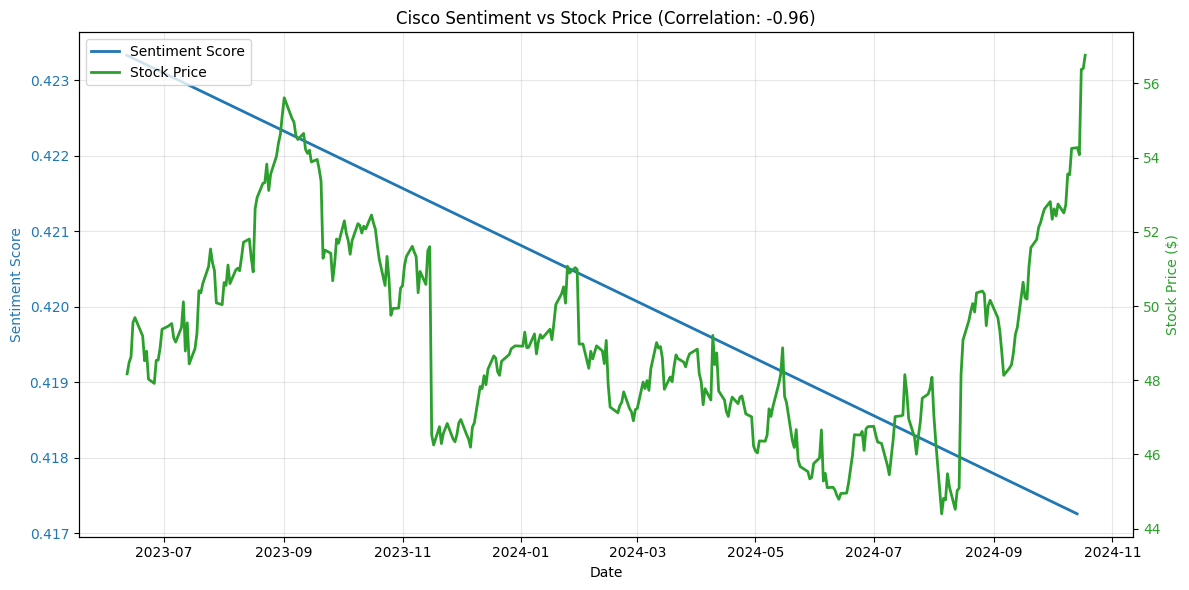

Plotting for Nike


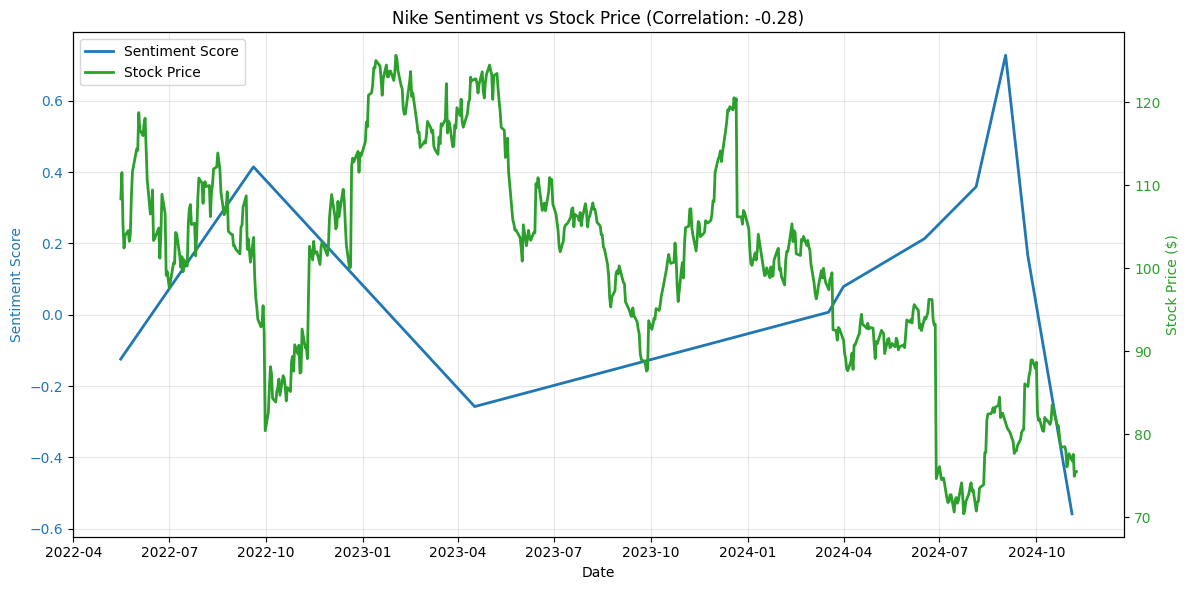

Plotting for Gap


ERROR:yfinance:$GPS: possibly delisted; no timezone found


No stock data available for Gap
Plotting for Walmart


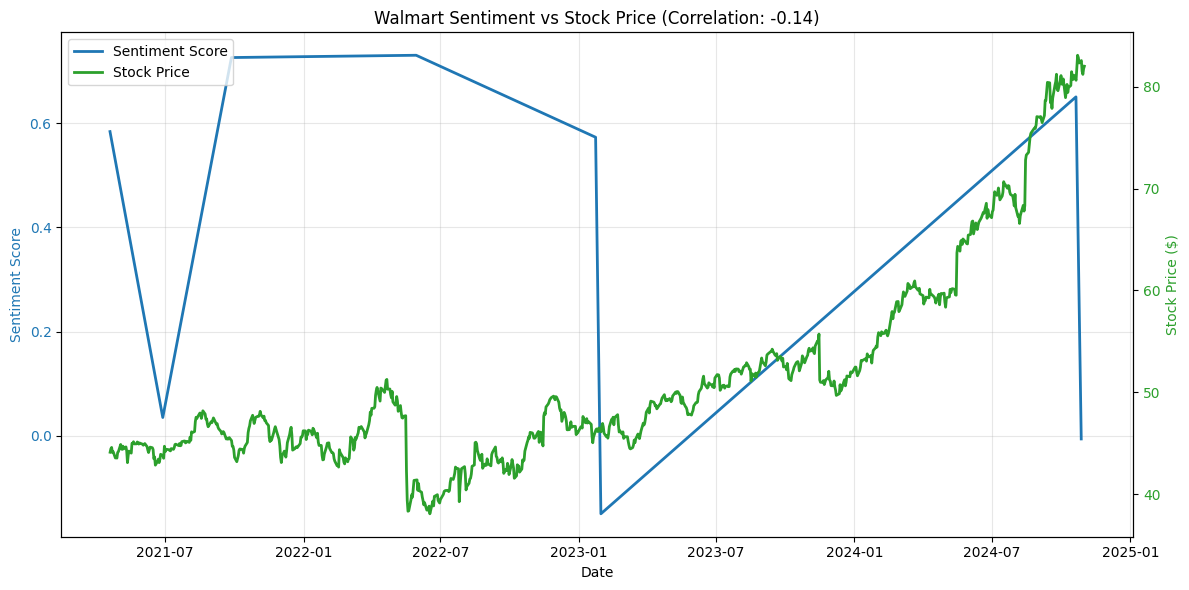

Plotting for Costco


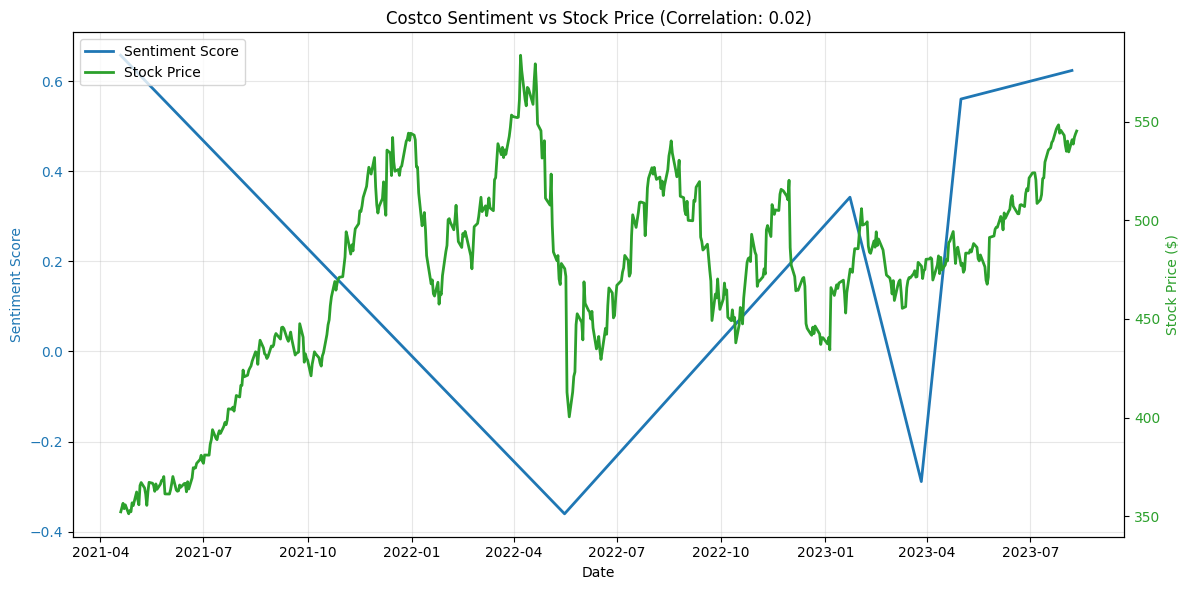

Plotting for Coca-Cola


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


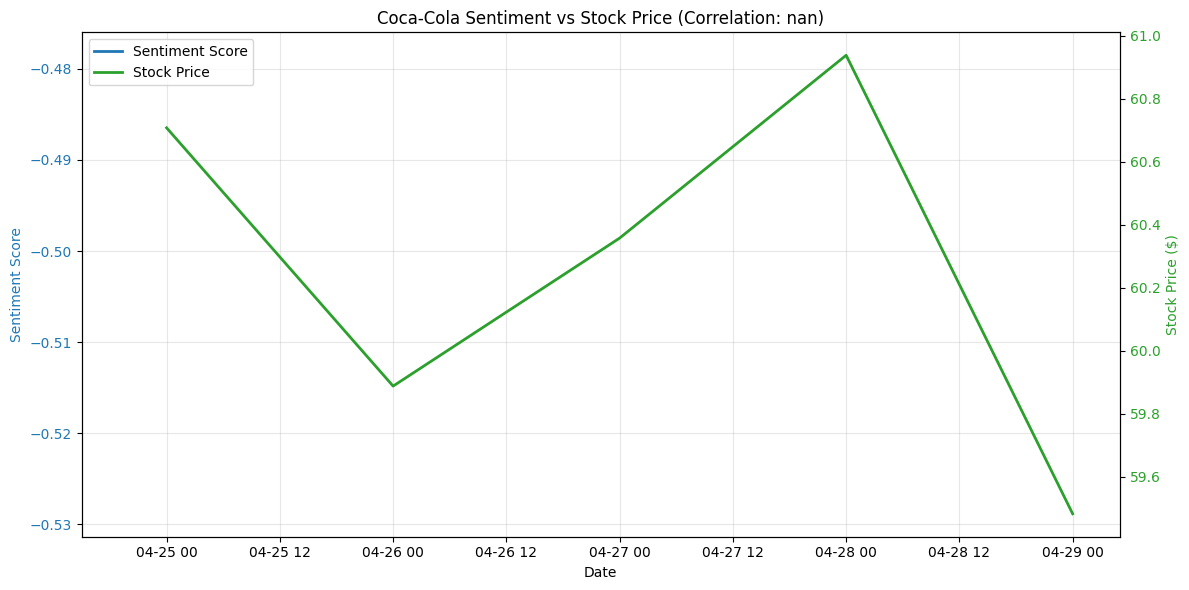

In [ ]:
import pandas as pd
import numpy as np
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Load the dataset
df = pd.read_csv('/content/wallstreetbets_sustainability_data_with_companies_combined.csv')

# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Function to get TextBlob sentiment
def get_textblob_sentiment(text):
    return TextBlob(str(text)).sentiment.polarity

# Function to get VADER sentiment
def get_vader_sentiment(text):
    sid = SentimentIntensityAnalyzer()
    return sid.polarity_scores(str(text))['compound']

# Apply sentiment analysis
df['textblob_sentiment'] = df['comment_body'].apply(get_textblob_sentiment)
df['vader_sentiment'] = df['comment_body'].apply(get_vader_sentiment)

df = df.rename(columns={'company_name': 'company'})
# Group by company and week
df['week'] = df['timestamp'].dt.to_period('W')
weekly_sentiment = df.groupby(['company', 'week']).agg({
    'textblob_sentiment': 'mean',
    'vader_sentiment': 'mean'
}).reset_index()

# Function to fetch stock data
def get_stock_data(ticker, start_date, end_date):
    stock = yf.Ticker(ticker)
    data = stock.history(start=start_date, end=end_date)
    return data['Close']

# Dictionary mapping companies to their stock tickers
company_tickers = {
    'Tesla': 'TSLA',
    'Apple': 'AAPL',
    'Microsoft': 'MSFT',
    'Amazon': 'AMZN',
    'Google': 'GOOGL',
    'Meta': 'META',
    'Netflix': 'NFLX',
    'NVIDIA': 'NVDA',
    'Adobe': 'ADBE',
    'Salesforce': 'CRM',
    'Intel': 'INTC',
    'Cisco': 'CSCO',
    'Nike': 'NKE',
    'Adidas': 'ADDYY',
    'Lululemon': 'LULU',
    'Under Armour': 'UAA',
    'Gap': 'GPS',
    'Walmart': 'WMT',
    'Target': 'TGT',
    'Costco': 'COST',
    'Coca-Cola': 'KO',
    'PepsiCo': 'PEP',
    'Johnson & Johnson': 'JNJ',
    'Procter & Gamble': 'PG',
    'Unilever': 'UL'
}

# First, modify the sentiment calculation to use a weighted average
# VADER is generally more accurate for social media text, so we'll give it more weight
# Calculate composite sentiment first
df['composite_sentiment'] = (0.7 * df['vader_sentiment'] + 0.3 * df['textblob_sentiment'])

# Then do the weekly grouping once
df['week'] = df['timestamp'].dt.to_period('W')
weekly_sentiment = df.groupby(['company', 'week']).agg({
    'composite_sentiment': 'mean'
}).reset_index()

# Then proceed with the plotting function

def plot_sentiment_and_stock(company, ticker):
    company_sentiment = weekly_sentiment[weekly_sentiment['company'] == company]
    if company_sentiment.empty:
        print(f"No data available for {company}")
        return

    start_date = company_sentiment['week'].min().start_time
    end_date = company_sentiment['week'].max().end_time

    stock_prices = get_stock_data(ticker, start_date, end_date)
    if stock_prices.empty:
        print(f"No stock data available for {company}")
        return

    # Create the plot
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot sentiment
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Sentiment Score', color='tab:blue')
    ax1.plot(company_sentiment['week'].dt.start_time,
             company_sentiment['composite_sentiment'],
             color='tab:blue',
             label='Sentiment Score',
             linewidth=2)
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.grid(True, alpha=0.3)

    # Plot stock price
    ax2 = ax1.twinx()
    ax2.set_ylabel('Stock Price ($)', color='tab:green')
    ax2.plot(stock_prices.index,
            stock_prices.values,
            color='tab:green',
            label='Stock Price',
            linewidth=2)
    ax2.tick_params(axis='y', labelcolor='tab:green')

    # Calculate correlation
    stock_prices_series = pd.Series(stock_prices.values,
                                  index=pd.PeriodIndex(stock_prices.index.date, freq='W'),
                                  name='stock_price')
    sentiment_series = company_sentiment.set_index('week')['composite_sentiment']
    sentiment_series.name = 'sentiment'

    common_dates = pd.merge(sentiment_series,
                          stock_prices_series,
                          left_index=True,
                          right_index=True,
                          how='inner')

    correlation = common_dates['sentiment'].corr(common_dates['stock_price'])

    plt.title(f'{company} Sentiment vs Stock Price (Correlation: {correlation:.2f})')

    # Combine legends from both axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

    fig.tight_layout()
    plt.show()


for company, ticker in company_tickers.items():
    if company in df['company'].unique():
        print(f"Plotting for {company}")
        plot_sentiment_and_stock(company, ticker)

